In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten,MinPool2D
import tensorflow

In [ ]:
my_experimented_model=Sequential()
my_experimented_model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(45,45,3)))
my_experimented_model.add(MinPool2D(pool_size=(1,1)))
my_experimented_model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
my_experimented_model.add(MinPool2D(pool_size=(2,2)))
my_experimented_model.add(Dropout(0.25))
my_experimented_model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
my_experimented_model.add(MinPool2D(pool_size=(2,2)))
my_experimented_model.add(Dropout(0.2))
my_experimented_model.add(Flatten())
my_experimented_model.add(Dense(1024))
my_experimented_model.add(Dropout(0.2))
my_experimented_model.add(Dense(56, activation='softmax'))

# compiling the sequential model
my_experimented_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

my_experimented_model.summary()


In [ ]:
import pathlib
import random
import shutil
from os import path

try:
    from tqdm import tqdm

    tqdm_is_installed = True
except ImportError:
    tqdm_is_installed = False


def list_dirs(directory):
    """Returns all directories in a given directory
    """
    return [f for f in pathlib.Path(directory).iterdir() if f.is_dir()]


def list_files(directory):
    """Returns all files in a given directory
    """
    return [
        f
        for f in pathlib.Path(directory).iterdir()
        if f.is_file() and not f.name.startswith(".")
    ]


def ratio(input, output="output", seed=1337, ratio=(0.8, 0.1, 0.1)):
    # make up for some impression
    assert round(sum(ratio), 5) == 1
    assert len(ratio) in (2, 3)

    if tqdm_is_installed:
        prog_bar = tqdm(desc=f"Copying files", unit=" files")

    for class_dir in list_dirs(input):
        split_class_dir_ratio(
            class_dir, output, ratio, seed, prog_bar if tqdm_is_installed else None
        )

    if tqdm_is_installed:
        prog_bar.close()


def fixed(input, output="output", seed=1337, fixed=(100, 100), oversample=False):
    # make sure its reproducible
    if isinstance(fixed, int):
        fixed = fixed

    assert len(fixed) in (1, 2)

    if tqdm_is_installed:
        prog_bar = tqdm(desc=f"Copying files", unit=" files")

    dirs = list_dirs(input)
    lens = []
    for class_dir in dirs:
        lens.append(
            split_class_dir_fixed(
                class_dir, output, fixed, seed, prog_bar if tqdm_is_installed else None
            )
        )

    if tqdm_is_installed:
        prog_bar.close()

    if not oversample:
        return

    max_len = max(lens)

    iteration = zip(lens, dirs)

    if tqdm_is_installed:
        iteration = tqdm(iteration, desc="Oversampling", unit=" classes")

    for length, class_dir in iteration:
        class_name = path.split(class_dir)[1]
        full_path = path.join(output, "train", class_name)
        train_files = list_files(full_path)
        for i in range(max_len - length):
            f_orig = random.choice(train_files)
            new_name = f_orig.stem + "_" + str(i) + f_orig.suffix
            f_dest = f_orig.with_name(new_name)
            shutil.copy2(f_orig, f_dest)


def setup_files(class_dir, seed):
    """Returns shuffled files
    """
    # make sure its reproducible
    random.seed(seed)

    files = list_files(class_dir)

    files.sort()
    random.shuffle(files)
    return files


def split_class_dir_fixed(class_dir, output, fixed, seed, prog_bar):
    """Splits one very class folder
    """
    files = setup_files(class_dir, seed)

    if not len(files) > sum(fixed):
        raise ValueError(
            f'The number of samples in class "{class_dir.stem}" are too few. There are only {len(files)} samples available but your fixed parameter {fixed} requires at least {sum(fixed)} files. You may want to split your classes by ratio.'
        )

    split_train = len(files) - sum(fixed)
    split_val = split_train + fixed[0]

    li = split_files(files, split_train, split_val, len(fixed) == 2)
    copy_files(li, class_dir, output, prog_bar)
    return len(files)


def split_class_dir_ratio(class_dir, output, ratio, seed, prog_bar):
    """Splits one very class folder
    """
    files = setup_files(class_dir, seed)

    split_train = int(ratio[0] * len(files))
    split_val = split_train + int(ratio[1] * len(files))

    li = split_files(files, split_train, split_val, len(ratio) == 3)
    copy_files(li, class_dir, output, prog_bar)


def split_files(files, split_train, split_val, use_test):
    """Splits the files along the provided indices
    """
    files_train = files[:split_train]
    files_val = files[split_train:split_val] if use_test else files[split_train:]

    li = [(files_train, "train"), (files_val, "val")]

    # optional test folder
    if use_test:
        files_test = files[split_val:]
        li.append((files_test, "test"))
    return li


def copy_files(files_type, class_dir, output, prog_bar):
    """Copies the files from the input folder to the output folder
    """
    # get the last part within the file
    class_name = path.split(class_dir)[1]
    for (files, folder_type) in files_type:
        full_path = path.join(output, folder_type, class_name)

        pathlib.Path(full_path).mkdir(parents=True, exist_ok=True)
        for f in files:
            if not prog_bar is None:
                prog_bar.update()
            shutil.copy2(f, full_path)

In [ ]:
!unzip '/content/drive/My Drive/Internship_Dataset/crohme_dataset2.zip'

Streaming output truncated to the last 5000 lines.
  inflating: crohme_dataset2/X/exp39780.jpg  
 extracting: crohme_dataset2/X/exp39805.jpg  
 extracting: crohme_dataset2/X/exp39807.jpg  
  inflating: crohme_dataset2/X/exp39814.jpg  
 extracting: crohme_dataset2/X/exp39835.jpg  
  inflating: crohme_dataset2/X/exp39839.jpg  
  inflating: crohme_dataset2/X/exp39843.jpg  
  inflating: crohme_dataset2/X/exp39849.jpg  
 extracting: crohme_dataset2/X/exp3987.jpg  
 extracting: crohme_dataset2/X/exp39896.jpg  
 extracting: crohme_dataset2/X/exp4010.jpg  
 extracting: crohme_dataset2/X/exp4011.jpg  
 extracting: crohme_dataset2/X/exp4012.jpg  
  inflating: crohme_dataset2/X/exp40122.jpg  
 extracting: crohme_dataset2/X/exp4013.jpg  
  inflating: crohme_dataset2/X/exp40130.jpg  
 extracting: crohme_dataset2/X/exp40134.jpg  
 extracting: crohme_dataset2/X/exp40138.jpg  
 extracting: crohme_dataset2/X/exp4020.jpg  
  inflating: crohme_dataset2/X/exp40200.jpg  
 extracting: crohme_dataset2/X/exp4

In [ ]:
data_dir='/content/crohme_dataset2/'
output_dir='/content/drive/My Drive/Internship_Dataset/2_gray_scale'
import os
#os.remove("/content/Dataset/extracted_images/.DS_Store")

In [ ]:
#for filename in os.listdir("/content/Dataset/extracted_images"):
  #print(filename)
len(os.listdir(data_dir))

56

In [ ]:
# Infos about our Dataset
nbr_of_pictures = []

lab = os.listdir("/content/crohme_dataset2")
for _, _, files in os.walk(r'/content/crohme_dataset2'):
    nbr_of_pictures.append(len(files))

nbr_of_pictures=nbr_of_pictures[1:]
#print nbr of pictures in every class
print("Number of samples in every class ...")
print(len(lab))
#sum=0
for i in range(56):  # 82 : Nbr of classes
    print(lab[i]," : ",nbr_of_pictures[i])
    #sum=sum+nbr_of_pictures[i]

Number of samples in every class ...
56
gt  :  65
!  :  224
pi  :  498
,  :  596
}  :  69
times  :  600
3  :  2469
neq  :  111
gamma  :  90
infty  :  386
leq  :  220
geq  :  147
lt  :  106
div  :  157
forward_slash  :  196
)  :  3978
beta  :  295
0  :  1810
(  :  3986
sqrt  :  1649
mu  :  46
theta  :  543
{  :  69
=  :  3640
+  :  5443
phi  :  83
prime  :  76
w  :  139
rightarrow  :  299
Delta  :  35
forall  :  9
tan  :  281
1  :  6327
4  :  1641
z  :  1075
8  :  731
exists  :  4
y  :  1895
cos  :  574
lambda  :  27
X  :  2818
7  :  753
ldots  :  139
alpha  :  383
]  :  201
sum  :  642
9  :  742
sin  :  783
sigma  :  52
in  :  15
6  :  812
integration  :  606
-  :  6022
2  :  6210
[  :  201
5  :  1008


(45, 45)


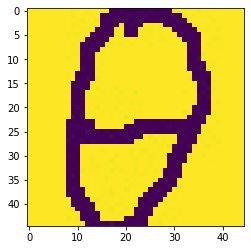

In [ ]:
img=plt.imread('/content/drive/My Drive/Internship_Dataset/2_gray_scale/test/theta/exp10692.jpg')
print(img.shape)
plt.imshow(img)

In [ ]:
SEED=999
import numpy as np

In [ ]:
labels1 = lab
print(labels1)
print(len(lab)," Classes : ",lab)
lab = np.array(lab)


['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty', 'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0', '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w', 'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8', 'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']', 'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2', '[', '5']
56  Classes :  ['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty', 'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0', '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w', 'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8', 'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']', 'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2', '[', '5']


In [ ]:
lab.shape
lab = lab.reshape((1,lab.shape[0]))
lab

array([['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty',
        'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0',
        '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w',
        'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8',
        'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']',
        'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2',
        '[', '5']], dtype='<U13')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
#import PY2
#from tensorflow.keras.utils.vis_utils import plot_model
import sklearn
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import backend as K
#from myModel.model import VGGNet
import matplotlib.pyplot as plt
#from imutils import paths#import pydot
import numpy as np
import argparse
import random
import pickle
import cv2
import os
# mlb = MultiLabelBinarizer()
# #labels = mlb.fit_transform(labels)
# #l.reshape((1,82))
# l=mlb.fit(lab)
# mlb.fit_transform(lab)

In [ ]:
path='/content/drive/My Drive/Internship_Dataset/'
f = open(path+ "/56_mlb.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()

In [ ]:
from PIL import Image  
import PIL  
path='/content/crohme_dataset2'
for files in os.listdir(path):
  for f in os.listdir(os.path.join(path,files)):
      img=cv2.imread(os.path.join(os.path.join(path,files),f))
      img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      #print(os.path.join(os.path.join(path,files),f))
      _,bin_img = cv2.threshold(img,0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
      kernel = np.ones((2,2)) 
      img = cv2.erode(bin_img, kernel,iterations=1)

      # #print(img.shape)
      cv2.imwrite(os.path.join(os.path.join(path,files),f),img)
       

In [ ]:
ratio(data_dir, output=output_dir, seed=999, ratio=(.8, .1, .1)) # default val

Streaming output truncated to the last 5000 lines.
Copying files: 39459 files [05:17, 137.62 files/s]


Copying files: 39474 files [05:17, 138.58 files/s]


Copying files: 39488 files [05:17, 133.51 files/s]


Copying files: 39502 files [05:17, 125.04 files/s]


Copying files: 39515 files [05:18, 120.77 files/s]


Copying files: 39528 files [05:18, 110.56 files/s]


Copying files: 39541 files [05:18, 113.81 files/s]


Copying files: 39555 files [05:18, 118.67 files/s]


Copying files: 39568 files [05:18, 119.04 files/s]


Copying files: 39581 files [05:18, 119.05 files/s]


Copying files: 39594 files [05:18, 121.02 files/s]


Copying files: 39609 files [05:18, 126.96 files/s]


Copying files: 39623 files [05:18, 125.39 files/s]


Copying files: 39638 files [05:19, 131.51 files/s]


Copying files: 39655 files [05:19, 140.59 files/s]


Copying files: 39673 files [05:19, 150.10 files/s]


Copying files: 39690 files [05:19, 155.02 files/s]


Copying files: 39706 files [05:19, 148.97 files/

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [ ]:
import os

train_dir='/content/drive/My Drive/Internship_Dataset/56_data/train'
val_dir='/content/drive/My Drive/Internship_Dataset/56_data/val'
test_dir='/content/drive/My Drive/Internship_Dataset/56_data/test'

In [ ]:
cnt=0
for files in os.listdir(train_dir):
    cnt=cnt+1
print(cnt)
print(len(os.listdir(train_dir)))
print(len(os.listdir(val_dir)))
print(os.listdir(train_dir))
print(os.listdir(val_dir))

56
56
56
['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty', 'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0', '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w', 'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8', 'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']', 'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2', '[', '5']
['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty', 'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0', '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w', 'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8', 'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']', 'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2', '[', '5']


In [ ]:
EPOCHS = 15
BS = 128 #Batch size
LR = 1e-3 #Learning rate 0.001

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
model_checking = ModelCheckpoint('/content/drive/My Drive/Internship_Dataset/model_with_56_classes_with_gray_scale.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
# Infos about our Dataset
nbr_of_pictures = []

lab = os.listdir("/content/crohme_dataset2")
for _, _, files in os.walk(r'/content/crohme_dataset2'):
    nbr_of_pictures.append(len(files))

nbr_of_pictures=nbr_of_pictures[1:]
#print nbr of pictures in every class
print("Number of samples in every class ...")
print(len(lab))
for i in range(56):  # 82 : Nbr of classes
    print(lab[i]," : ",nbr_of_pictures[i])

Number of samples in every class ...
56
gt  :  65
!  :  224
pi  :  498
,  :  596
}  :  69
times  :  600
3  :  2469
neq  :  111
gamma  :  90
infty  :  386
leq  :  220
geq  :  147
lt  :  106
div  :  157
forward_slash  :  196
)  :  3978
beta  :  295
0  :  1810
(  :  3986
sqrt  :  1649
mu  :  46
theta  :  543
{  :  69
=  :  3640
+  :  5443
phi  :  83
prime  :  76
w  :  139
rightarrow  :  299
Delta  :  35
forall  :  9
tan  :  281
1  :  6327
4  :  1641
z  :  1075
8  :  731
exists  :  4
y  :  1895
cos  :  574
lambda  :  27
X  :  2818
7  :  753
ldots  :  139
alpha  :  383
]  :  201
sum  :  642
9  :  742
sin  :  783
sigma  :  52
in  :  15
6  :  812
integration  :  606
-  :  6022
2  :  6210
[  :  201
5  :  1008


In [ ]:
labels = []
#Nbr of training images
train_samples_nbr  = sum(len(files) for _, _, files in os.walk(r'/content/drive/My Drive/Internship_Dataset/2_gray_scale/train'))
#Nbr of testing images
val_samples_nbr  = sum(len(files) for _, _, files in os.walk(r'/content/drive/My Drive/Internship_Dataset/2_gray_scale/val'))

In [ ]:
print(train_samples_nbr)

49558


In [ ]:
labels1 = lab
print(labels1)
print(len(lab)," Classes : ",lab)
lab = np.array(lab)


['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty', 'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0', '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w', 'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8', 'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']', 'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2', '[', '5']
56  Classes :  ['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty', 'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0', '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w', 'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8', 'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']', 'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2', '[', '5']


In [ ]:
lab.shape
lab = lab.reshape((1,lab.shape[0]))
lab

array([['gt', '!', 'pi', ',', '}', 'times', '3', 'neq', 'gamma', 'infty',
        'leq', 'geq', 'lt', 'div', 'forward_slash', ')', 'beta', '0',
        '(', 'sqrt', 'mu', 'theta', '{', '=', '+', 'phi', 'prime', 'w',
        'rightarrow', 'Delta', 'forall', 'tan', '1', '4', 'z', '8',
        'exists', 'y', 'cos', 'lambda', 'X', '7', 'ldots', 'alpha', ']',
        'sum', '9', 'sin', 'sigma', 'in', '6', 'integration', '-', '2',
        '[', '5']], dtype='<U13')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
#import PY2
#from tensorflow.keras.utils.vis_utils import plot_model
import sklearn
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import backend as K
#from myModel.model import VGGNet
import matplotlib.pyplot as plt
#from imutils import paths#import pydot
import numpy as np
import argparse
import random
import pickle
import cv2
import os
# mlb = MultiLabelBinarizer()
# #labels = mlb.fit_transform(labels)
# #l.reshape((1,82))
# l=mlb.fit(lab)
# mlb.fit_transform(lab)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.0,
    featurewise_center=False,# set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0.0,  # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally
    height_shift_range=0.0,  # randomly shift images vertically
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
    )

# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(45,45),
    batch_size=256,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(45, 45),
    batch_size=256,
    class_mode='categorical')

Found 49558 images belonging to 56 classes.
Found 6172 images belonging to 56 classes.


In [ ]:
history = my_experimented_model.fit(
    train_generator,
    steps_per_epoch=train_samples_nbr // 256,
    epochs=15,
)

UnimplementedError: ignored

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(45, 45),
    batch_size=BS,
    class_mode='categorical')

Found 6246 images belonging to 56 classes.


In [ ]:
my_experimented_model.evaluate_generator( test_generator, 10, max_queue_size = 10,
  workers = 1)


Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.19006407260894775, 0.9515625238418579]

In [ ]:
my_experimented_model=tensorflow.keras.models.load_model('/content/drive/My Drive/Internship_Dataset/model_with_56_classes.h5')

In [ ]:
import pickle
mlb = pickle.loads(open('/content/drive/My Drive/Internship_Dataset/56_mlb.pickle', "rb").read())

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys


OUTPUT_DIR = '/content/drive/My Drive/Internship_Dataset/segmented'

#------------------Functions------------------#
def line_array(array):
        list_x_upper = []
        list_x_lower = []
        for y in range(5, len(array) - 5):
            s_a, s_p = strtline(y, array)
            e_a, e_p = endline(y, array)
            if s_a >= 7 and s_p >= 5:
                list_x_upper.append(y)
            if e_a >= 5 and e_p >= 7:
                list_x_lower.append(y)

        return list_x_upper, list_x_lower
def strtline(y, array):
        count_ahead = 0
        count_prev = 0
        for i in array[y:y+10]:
            if i > 3:
                count_ahead += 1

        for i in array[y-10:y]:
            if i==0:
                count_prev += 1 

        return count_ahead, count_prev
def endline(y, array):
        count_ahead = 0
        count_prev = 0
        for i in array[y:y+10]:
            if i==0:
                count_ahead += 1

        for i in array[y-10:y]:
            if i > 3:
                count_prev += 1

        return count_ahead, count_prev

def endline_word(y, array, a):
        count_ahead = 0
        count_prev = 0
        for i in array[y:y+2*a]:
            if i < 2:
                count_ahead+= 1  
        for i in array[y-a:y]:
            if i > 2:
                count_prev += 1  
        return count_prev ,count_ahead
def end_line_array(array, a):
        list_endlines = []
        for y in range(len(array)):
            e_p, e_a = endline_word(y, array, a)
            # print(e_p, e_a)
            if e_a >= int(1.5*a) and e_p >= int(0.7*a):
                list_endlines.append(y)
        return list_endlines
def refine_endword(array):
        refine_list = []
        for y in range(len(array)-1):
            if array[y]+1 < array[y+1]:
                refine_list.append(array[y])

        if len(array) != 0:
            refine_list.append(array[-1])
        return refine_list
def refine_array(array_upper, array_lower):
        upperlines = []
        lowerlines = []
        for y in range(len(array_upper)-1):
            if array_upper[y] + 5 < array_upper[y+1]:
                upperlines.append(array_upper[y]-10)
        for y in range(len(array_lower)-1):
            if array_lower[y] + 5 < array_lower[y+1]:
                lowerlines.append(array_lower[y]+10)

        upperlines.append(array_upper[-1]-10)
        lowerlines.append(array_lower[-1]+10)

        return upperlines, lowerlines
def letter_width(contours):
        letter_width_sum = 0
        count = 0
        for cnt in contours:
            if cv2.contourArea(cnt) > 10:
                x,y,w,h = cv2.boundingRect(cnt)
                letter_width_sum += w
                count += 1

        return letter_width_sum/count


def end_wrd_dtct(lines, i, bin_img, mean_lttr_width, total_width,final_thr):
        count_y = np.zeros(shape = total_width)
        for x in range(total_width):
            for y in range(lines[i][0],lines[i][1]):
                if bin_img[y][x] == 255:
                    count_y[x] += 1

        end_lines = end_line_array(count_y, int(mean_lttr_width))
        endlines = refine_endword(end_lines)
        for x in endlines:
            print("in end_wrd_dtct")
            final_thr[lines[i][0]:lines[i][1], x] = 255
            #plt.imshow(final_thr)
        return endlines

def get_letter_rect(k, contours):
        "Helper function for properly identifying '=' symbol. OpenCV"
        "will treat 2 dashes of 'sign' as separate contours, thus this"
        "will help to identify and merge them into a single '=' contour"
        valid = True
        x,y,w,h = cv2.boundingRect(contours[k])
        for i in range(len(contours)):
            cnt = contours[i]
            if i == k:
                continue
            elif cv2.contourArea(cnt) < 50:
                continue

            x1,y1,w1,h1 = cv2.boundingRect(cnt)

            if abs(x1 + w1/2 - (x + w/2)) < 50:
                if y1 > y:
                    h = abs(y - (y1 + h1))
                    w = abs(x - (x1 + w1))
                else:
                    valid = False
                break

        return (valid,x,y,w,h)
def letter_seg(lines_img, x_lines, i):
        copy_img = lines_img[i].copy()
        x_linescopy = x_lines[i].copy()

        letter_img = []
        letter_k = []

        contours = cv2.findContours(copy_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
        for k in range(len(contours)):
            cnt = contours[k]
            if cv2.contourArea(cnt) < 50:
                continue

            valid,x,y,w,h = get_letter_rect(k, contours)
            if valid:
                letter_k.append((x,y,w,h))

        letter = sorted(letter_k, key=lambda student: student[0])
        #print(letter)

        word = 1
        letter_index = 0
        print(letter)
        for e in range(len(letter)):
            if(letter[e][0]<x_linescopy[0]):
                letter_index += 1
                letter_img_tmp = lines_img[i][letter[e][1]-5:letter[e][1]+letter[e][3]+5,letter[e][0]-5:letter[e][0]+letter[e][2]+5]
                letter_img = letter_img_tmp
                print(letter_img.shape)
                cv2.resize(letter_img_tmp, dsize =(45, 45), interpolation = cv2.INTER_AREA)
                cv2.imwrite(OUTPUT_DIR+str(i+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', 255-letter_img)
                image.append(255-letter_img)
                X.append(letter[e][0])
                Y.append(letter[e][1])
                X1.append(letter[e][2])
                Y1.append(letter[e][3])
                CX.append((letter[e][0]+letter[e][2])/2)
                CY.append((letter[e][1]+letter[e][3])/2)
                #print(letter[e][0],letter[e][1],letter[e][2],letter[e][3])
            else:
                x_linescopy.pop(0)
                word += 1
                letter_index = 1
                letter_img_tmp = lines_img[i][letter[e][1]-5:letter[e][1]+letter[e][3]+5,letter[e][0]-5:letter[e][0]+letter[e][2]+5]
                letter_img = cv2.resize(letter_img_tmp, dsize =(45, 45), interpolation = cv2.INTER_AREA)
                cv2.imwrite(OUTPUT_DIR+str(i+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', 255-letter_img_tmp)
                image.append(255-letter_img)
                X.append(letter[e][0])
                Y.append(letter[e][1])
                X1.append(letter[e][2])
                Y1.append(letter[e][3])
                CX.append((letter[e][0]+letter[e][2])/2)
                CY.append((letter[e][1]+letter[e][3])/2)
                #print(letter[e][0],x_linescopy[0], word)

def adjust_gamma(image,gamma):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)                
def image_segmentation(filepath):
        # -------------Thresholding Image--------------#
        print("\n........Program Initiated.......\n")
        src_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        orig_height, orig_width = src_img.shape

        print("\n Resizing Image........")
        width = 2000
        height = int(width * orig_height / orig_width)
        src_img = cv2.resize(src_img, dsize=(width, height), interpolation=cv2.INTER_AREA)

        print("#---------Image Info:--------#")
        print("\tHeight =", height, "\n\tWidth =", width)
        print("#----------------------------#")
        print("Applying Adaptive Threshold with kernel :- 21 X 21")

        PIXEL_SET = 255
        kernel_size = 21
        normalized_mean = 20
#         bin_img = cv2.adaptiveThreshold(src_img, PIXEL_SET, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, kernel_size,
#                                         normalized_mean)
        print(src_img.shape)
        equ = adjust_gamma(src_img,3.5)
        #plt.imshow(equ,cmap="gray")

        _,bin_img = cv2.threshold(equ,0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        plt.imshow(bin_img,cmap="gray")
#         kernel = np.array([[-1,-1,-1], 
#                    [-1, 9,-1],
#                    [-1,-1,-1]])
#         sharpened = cv2.filter2D(image, -1, kernel)

        print("Noise Removal From Image.........")
#         kernel = np.array([[-1,-1,-1], 
#                    [-1, -9,-1],
#                    [-1,-1,-1]])
        final_thr = cv2.erode(bin_img,(3,3),cv2.MORPH_ELLIPSE)
        #plt.imshow(final_thr,cmap="gray")
        contr_retrival = final_thr.copy()
        #print("coming here")

        # -------------/Thresholding Image-------------#

        # -------------Line Detection------------------#
        print("Beginning Character Semenation..............")
        count_x = np.zeros(shape=(height))
        for y in range(height):
            for x in range(width):
                if bin_img[y][x] == PIXEL_SET:
                    count_x[y] += 1
        
        print(count_x)
        upper_lines, lower_lines = line_array(count_x)
        upperlines, lowerlines = refine_array(upper_lines, lower_lines)
        print(upperlines)
        print(lowerlines)
        if len(upperlines) == len(lowerlines):
            lines = []
            for y in upperlines:
                final_thr[y][:] = PIXEL_SET
            for y in lowerlines:
                final_thr[y][:] = PIXEL_SET
            for y in range(len(upperlines)):
                lines.append((upperlines[y], lowerlines[y]))
        else:
            print("Too much noise in image, unable to process.\nPlease try with another image. Ctrl-C to exit:- ")
            #showimages()
            #k = cv2.waitKey(0)
            #while 1:
                #k = cv2.waitKey(0)
                #if k & 0xFF == ord('q'):
                    #cv2.destroyAllWindows()
            exit()

        lines = np.array(lines)
        no_of_lines = len(lines)
        print("\nGiven Text has   # ", no_of_lines, " #   no. of lines")

        lines_img = []
        for i in range(no_of_lines):
            lines_img.append(bin_img[lines[i][0]:lines[i][1], :])

        # -------------/Line Detection-----------------#

        # -------------Letter Width Calculation--------#

        contours= cv2.findContours(contr_retrival, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        cv2.drawContours(src_img, contours, -1, (0, 255, 0), 1)

        mean_lttr_width = letter_width(contours)
        print("\nAverage Width of Each Letter:- ", mean_lttr_width)

        # -------------/Letter Width Calculation-------#

        # --------------Word Detection-----------------#
        x_lines = []
        for i in range(len(lines_img)):
            x_lines.append(end_wrd_dtct(lines, i, bin_img, mean_lttr_width, width,final_thr))

        for i in range(len(x_lines)):
            x_lines[i].append(width)

        # -------------/Word Detection-----------------#

        # -------------Letter Segmentation-------------#

        for i in range(len(lines)):
            letter_seg(lines_img, x_lines, i)

        # ------------\Letter Segmentation-------------#

        # -------------Character segmenting------------#

        contours = cv2.findContours(final_thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        for cnt in contours:
            if cv2.contourArea(cnt) > 20:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(src_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                

In [ ]:
is_digit=False
is_var=False
is_constant=False
prev_digit=False
prev_var=False
prev_constant=False
other=False

In [ ]:
var=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b'
    ,'c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','COS','cos','sin'
    ,'SIN','tan','TAN']

In [ ]:
digit=['0','1','2','3','4','5','6','7','8','9']

In [ ]:
constant=['alpha','beta','lamba','theta','Delta','mu']


........Program Initiated.......


 Resizing Image........
#---------Image Info:--------#
	Height = 426 
	Width = 2000
#----------------------------#
Applying Adaptive Threshold with kernel :- 21 X 21
(426, 2000)
Noise Removal From Image.........
Beginning Character Semenation..............
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  12.  17.  22.
  28.  30.  34.  29.  27.  22.  19.  19.  17.  17.  15.  13.  14.  14.
  13.  13.   9.  10.  10.   9.   8.   7.   7.   6.   6.   8.   8.  22.
  25.  27.  30.  33.  34.  53.  50.  53.  53.  53.  54.  38.  33.  23.
  16.  21.  33.  40.  43.  45.  42.  33.  32.  32.  32.  34.  34.  33.
  33.  34.  36.  37.  37.  54.  61.  66.  65.  64.  58.  55.  60.  71.
  67.  67.  67.  64.  60.  50.  47.  44.  37.  36.  35.  43.  46.  6

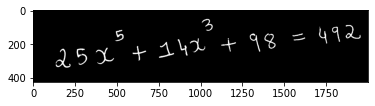

In [ ]:
X=[]
Y=[]
X1=[]
Y1=[]
CX=[]
CY=[]
image=[]
is_digit=False
is_var=False
is_constant=False
prev_digit=False
prev_var=False
prev_constant=False?
other=False
image_segmentation('/content/WhatsApp Image 2020-07-26 at 10.19.48 PM.jpeg')

In [ ]:

from keras.models import load_model
import pandas as pd
import numpy as np
from PIL import Image,ImageOps
#import CharacterSegmentation as cs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
dictionary = dict(zip(X, image))
import collections
od = collections.OrderedDict(sorted(dictionary.items()))
ima=[]

In [ ]:
for image in od.values(): 
    ima.append(image) 

In [ ]:
ima=np.array(ima)

<Figure size 432x288 with 0 Axes>

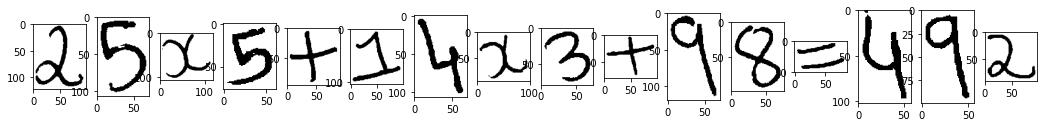

In [ ]:
fig = plt.figure()
figure(figsize=(18,18))
cnt=1
for i in range(len(ima)):
    ax1 = plt.subplot(2,len(ima),cnt)
    ax1.imshow(ima[i],cmap="gray")
    cnt+=1

In [ ]:
#fig = plt.figure()
#figure(figsize=(18,18))
cnt=1
for i in range(len(ima)):
    #ax1 = plt.subplot(2,len(ima),cnt)
    ima[i]=cv2.resize(ima[i],(45,45),interpolation = cv2.INTER_LINEAR)
    # ima[i]=ima[i].reshape((-1,28,28,1))
    #ax1.imshow(ima[i])
    #print(ima[i].shape)
    cnt+=1

In [ ]:

from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import tensorflow
for i in range(len(ima)):
    #ax1 = plt.subplot(2,len(ima),cnt)
    ima[i]=tensorflow.image.grayscale_to_rgb(tensorflow.expand_dims(ima[i], axis=2))
    ima[i]=np.array(ima[i])
    ima[i] = ima[i].astype("float") / 255.0
    ima[i] = img_to_array(ima[i])
    ima[i] = np.expand_dims(ima[i], axis=0)

In [ ]:
result=""
is_digit=False
is_var=False
is_constant=False
prev_digit=False
prev_var=False
prev_constant=False
other=False

In [ ]:
for im in ima:
  proba = my_experimented_model.predict(im)[0]
  idxs = np.argsort(proba)[::-1][:1]
  for (i, j) in enumerate(idxs):
	# build the label and draw the label on the image
    #print(i)
    temp=mlb.classes_[j]
    print(mlb.classes_[j])
    label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
    print(label)
    print()
    other=True
    for k in var:
      if k==temp:
        is_var=True
        break
    
    if is_var==False:
      for k in digit:
        if k==temp:
          is_digit=True
          break

    elif is_digit==False:
      for k in constant:
        if k==temp:
          is_constant=True
          break

    if prev_digit==True:
      if is_var==True:
        result+=str(temp)
      elif is_constant==True:
        result+=str(temp)
      elif is_digit==True:
        result+=str(temp)
      else:
        result+=str(temp)

    elif prev_constant==True:
      if is_var==True:
        result+=str(temp)
      elif is_constant==True:
        result+=str(temp)
      elif is_digit==True:
        result+=('^'+str(temp))
      else:
        result+=str(temp)
    elif prev_var==True:
      if is_var==True:
        result+=str(temp)
      elif is_constant==True:
        result+=str(temp)
      elif is_digit==True:
        result+=('^'+str(temp))
      else:
        result+=str(temp)
    else:
      result+=str(temp)
    prev_var=is_var
    prev_digit=is_digit
    prev_constant=is_constant
    is_constant=False
    is_digit=False
    is_var=False
    


2
2: 98.31%

5
5: 100.00%

X
X: 96.35%

5
5: 99.83%

+
+: 99.98%

1
1: 99.52%

4
4: 99.90%

X
X: 91.98%

3
3: 99.89%

+
+: 99.99%

9
9: 67.00%

8
8: 96.05%

=
=: 80.64%

4
4: 100.00%

9
9: 94.95%

2
2: 99.56%



In [ ]:
print(result)

25X^5+14X^3+98=492


(1, 45, 45, 3)
[6.3529633e-11 2.5981034e-10 8.0160428e-10 2.4508061e-06 3.1788534e-09
 8.4397914e-12 3.8583163e-09 1.2820111e-09 1.4461899e-09 6.6760583e-11
 8.4307867e-05 9.8955752e-08 4.4041240e-06 1.0965652e-11 3.1011211e-08
 1.4872770e-14 5.1067845e-15 5.7242040e-08 1.4738706e-06 7.0206951e-08
 7.2731231e-13 3.9914937e-07 2.1615264e-07 5.4199761e-04 2.3182492e-13
 6.1458205e-10 2.0175945e-05 2.5196045e-10 6.1037710e-08 1.3669032e-12
 1.8816542e-11 1.7476159e-08 1.9071867e-06 3.1743938e-13 6.6286309e-05
 2.4170885e-10 2.2158718e-10 6.9670827e-12 5.4989238e-07 1.5003087e-07
 6.7389267e-03 4.6351845e-03 3.2627463e-09 1.8014669e-10 4.7567191e-06
 7.6710203e-05 1.4323139e-08 3.5548560e-08 9.8734015e-01 6.3053045e-07
 7.2778357e-07 4.7784572e-04 9.4654857e-12 7.6136430e-08 2.2640334e-09
 3.1749815e-07]


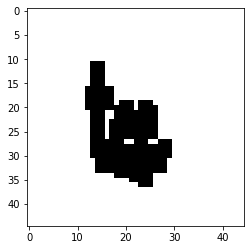

In [ ]:
#imag=cv2.imread('/content/WhatsApp Image 2020-07-26 at 10.42.07 AM.jpeg')
src_img = cv2.imread('/content/WhatsApp Image 2020-07-26 at 11.19.51 AM.jpeg', cv2.IMREAD_GRAYSCALE)
orig_height, orig_width = src_img.shape

        #print("\n Resizing Image........")
width = 2000
# height = int(width * orig_height / orig_width)
# src_img = cv2.resize(src_img, dsize=(width, height), interpolation=cv2.INTER_AREA)
# plt.imshow(src_img)

PIXEL_SET = 255
kernel_size = 21
normalized_mean = 20
#         bin_img = cv2.adaptiveThreshold(src_img, PIXEL_SET, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, kernel_size,
#                                         normalized_mean)
        #print(src_img.shape)
equ = adjust_gamma(src_img,1
                   )
plt.imshow(equ,cmap="gray")
equ = cv2.resize(equ, (45, 45),interpolation=cv2.INTER_LINEAR)
plt.imshow(equ)
_,bin_img = cv2.threshold(equ,0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#plt.imshow(bin_img)
# plt.imshow(bin_img,cmap="gray")
#         kernel = np.array([[-1,-1,-1], 
#                    [-1, 9,-1],
#                    [-1,-1,-1]])
#         sharpened = cv2.filter2D(image, -1, kernel)

        #print("Noise Removal From Image.........")
#         kernel = np.array([[-1,-1,-1], 
#                    [-1, -9,-1],
#                    [-1,-1,-1]])
final_thr = cv2.dilate(bin_img,(3,3),cv2.MORPH_ELLIPSE)




#print(image.shape)
kernel = np.ones((3,3)) 
final_thr = cv2.dilate(final_thr, kernel,iterations=1) 
final_thr = ~final_thr

final_thr = final_thr.astype("float") / 255.0

final_thr = img_to_array(final_thr)

final_thr = cv2.cvtColor(final_thr,cv2.COLOR_GRAY2RGB)
plt.imshow(final_thr)
final_thr = np.expand_dims(final_thr, axis=0)
print(final_thr.shape)

proba = my_experimented_model.predict(final_thr)[0]

print(proba)
idxs = np.argsort(proba)[::-1][:10]

In [ ]:
for (i, j) in enumerate(idxs):
	# build the label and draw the label on the image
  print(i)
  print(mlb.classes_[j])
  label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
  print(label)

0
tan
tan: 98.73%
1
phi
phi: 0.67%
2
pi
pi: 0.46%
3
cos
cos: 0.05%
4
w
w: 0.05%
5
4
4: 0.01%
6
sin
sin: 0.01%
7
lambda
lambda: 0.01%
8
forall
forall: 0.00%
9
sigma
sigma: 0.00%


ValueError: ignored

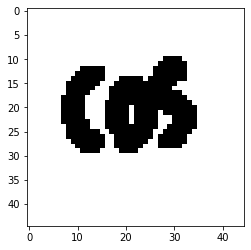

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
image = cv2.imread('/content/WhatsApp Image 2020-07-26 at 7.48.32 PM.jpeg', cv2.IMREAD_GRAYSCALE)


# output = imutils.resize(image, width=400)
# plt.imshow(output)
# # pre-process the image for classification
image = cv2.resize(image, (45, 45),interpolation=cv2.INTER_LINEAR)

image=cv2.GaussianBlur(image,(3,3),0)
# plt.imshow(image)
_,image = cv2.threshold(image,0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3)) 
image = cv2.dilate(image, kernel,iterations=1)
# #plt.imshow(bin_img)
# # plt.imshow(bin_img,cmap="gray")
# kernel = np.array([[-1,-1,-1], 
#                    [-1, 9,-1],
#                    [-1,-1,-1]])
# sharpened = cv2.filter2D(bin_img, -1, kernel)

#         #print("Noise Removal From Image.........")
# kernel = np.array([[-1,-1,-1], 
#                     [-1, -9,-1],
#                     [-1,-1,-1]])
# final_thr = cv2.erode(bin_img,kernel,cv2.MORPH_ELLIPSE)




# #print(image.shape)
# kernel = np.ones((5,5)) 
# final_thr = cv2.dilate(sharpened, kernel,iterations=2) 
# final_thr =255-final_thr


# final_thr = img_to_array(final_thr)
image=255-image
plt.imshow(image,cmap='gray')
#image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = image.astype("float") / 255.0
#plt.imshow(final_thr)
image = np.expand_dims(image, axis=0)
#print(final_thr.shape)

proba = my_experimented_model.predict(image)[0]

print(proba)
idxs = np.argsort(proba)[::-1][:10]



In [ ]:
# print("[INFO] classifying image...")
# #proba = my_experimented_model.predict(image)[0]
# idxs = np.argsort(proba)[::-1][:2]
# loop over the indexes of the high confidence class labels

In [ ]:
for (i, j) in enumerate(idxs):
    print(i)
    print(mlb.classes_[j])
    # build the label and draw the label on the image
    label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
    print(label)

0
theta
theta: 90.08%
1
4
4: 9.12%
2
beta
beta: 0.37%
3
Delta
Delta: 0.31%
4
8
8: 0.03%
5
mu
mu: 0.02%
6
tan
tan: 0.02%
7
infty
infty: 0.01%
8
phi
phi: 0.01%
9
z
z: 0.01%


In [ ]:
import math
import cv2
import numpy as np


def wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=0):
	"""Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf
	
	Args:
		img: grayscale uint8 image of the text-line to be segmented.
		kernelSize: size of filter kernel, must be an odd integer.
		sigma: standard deviation of Gaussian function used for filter kernel.
		theta: approximated width/height ratio of words, filter function is distorted by this factor.
		minArea: ignore word candidates smaller than specified area.
		
	Returns:
		List of tuples. Each tuple contains the bounding box and the image of the segmented word.
	"""

	# apply filter kernel
	kernel = createKernel(kernelSize, sigma, theta)
	imgFiltered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
	(_, imgThres) = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	imgThres = 255 - imgThres

	# find connected components. OpenCV: return type differs between OpenCV2 and 3
	if cv2.__version__.startswith('3.'):
		(_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	else:
		(components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

	# append components to result
	res = []
	for c in components:
		# skip small word candidates
		if cv2.contourArea(c) < minArea:
			continue
		# append bounding box and image of word to result list
		currBox = cv2.boundingRect(c) # returns (x, y, w, h)
		(x, y, w, h) = currBox
		currImg = img[y:y+h, x:x+w]
		res.append((currBox, currImg))

	# return list of words, sorted by x-coordinate
	return sorted(res, key=lambda entry:entry[0][0])


def prepareImg(img, height):
	"""convert given image to grayscale image (if needed) and resize to desired height"""
	assert img.ndim in (2, 3)
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	h = img.shape[0]
	factor = height / h
	return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def createKernel(kernelSize, sigma, theta):
	"""create anisotropic filter kernel according to given parameters"""
	assert kernelSize % 2 # must be odd size
	halfSize = kernelSize // 2
	
	kernel = np.zeros([kernelSize, kernelSize])
	sigmaX = sigma
	sigmaY = sigma * theta
	
	for i in range(kernelSize):
		for j in range(kernelSize):
			x = i - halfSize
			y = j - halfSize
			
			expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
			xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
			yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)
			
			kernel[i, j] = (xTerm + yTerm) * expTerm

	kernel = kernel / np.sum(kernel)
	return kernel

Segmented into 1 words


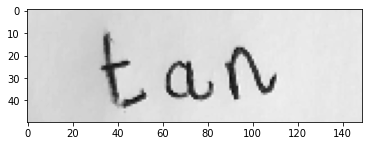

In [ ]:
img = prepareImg(cv2.imread('/content/WhatsApp Image 2020-07-26 at 4.49.09 PM.jpeg'), 50)
		
		# execute segmentation with given parameters
		# -kernelSize: size of filter kernel (odd integer)
		# -sigma: standard deviation of Gaussian function used for filter kernel
		# -theta: approximated width/height ratio of words, filter function is distorted by this factor
		# - minArea: ignore word candidates smaller than specified area
res = wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=100)
		
		# write output to 'out/inputFileName' directory
		
		# iterate over all segmented words
print('Segmented into %d words'%len(res))
for (j, w) in enumerate(res):
	(wordBox, wordImg) = w
	(x, y, w, h) = wordBox
	#cv2.rectangle(img,(x,y),(x+w,y+h),0,1) # draw bounding box in summary image
	plt.imshow(img,cmap='gray')
plt.savefig('/content/img.jpg')

(1, 45, 45, 3)
[1.9872827e-26 8.9094338e-20 1.6927012e-19 1.5222043e-10 3.8620274e-20
 4.1198651e-21 3.5473454e-15 2.7635173e-16 1.3258087e-12 4.8556520e-19
 9.7883275e-09 1.6870301e-17 8.8922169e-13 4.8036522e-15 1.3571773e-15
 1.5360369e-22 4.5956515e-23 6.6009828e-12 5.0183980e-06 2.2200646e-17
 9.4762950e-22 7.4024120e-09 3.0972601e-16 8.7813650e-09 5.9577249e-24
 2.7102315e-16 1.2407783e-11 1.7621597e-19 8.8976025e-15 2.6046931e-17
 6.8891624e-22 7.5860889e-15 1.5115686e-10 4.5671595e-25 7.0129791e-10
 3.8079613e-26 3.2275283e-16 9.3292548e-18 1.4421604e-12 2.8268695e-11
 1.3106423e-12 1.8673058e-08 9.5129675e-18 5.2797605e-17 6.4802870e-16
 2.3200191e-05 2.9024645e-18 2.6227723e-15 9.9997175e-01 4.6212023e-12
 2.5452319e-11 8.1644178e-11 1.0026633e-18 2.2153359e-09 2.6373147e-19
 1.6239968e-19]


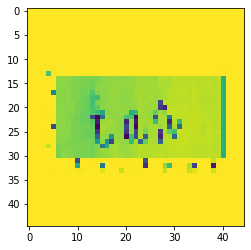

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
image = cv2.imread('/content/img.jpg', cv2.IMREAD_GRAYSCALE)
output = imutils.resize(image, width=400)
plt.imshow(output)
# pre-process the image for classification
image = cv2.resize(image, (45, 45),interpolation=cv2.INTER_CUBIC)
plt.imshow(image)
_,bin_img = cv2.threshold(image,0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#plt.imshow(bin_img)
# plt.imshow(bin_img,cmap="gray")
kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
sharpened = cv2.filter2D(bin_img, -1, kernel)

        #print("Noise Removal From Image.........")
kernel = np.array([[-1,-1,-1], 
                    [-1, -9,-1],
                    [-1,-1,-1]])
final_thr = cv2.dilate(bin_img,kernel,cv2.MORPH_ELLIPSE)




#print(image.shape)
kernel = np.ones((5,5)) 
final_thr = cv2.dilate(sharpened, kernel,iterations=2) 
final_thr =255-final_thr

final_thr = final_thr.astype("float") / 255.0

final_thr = img_to_array(final_thr)

final_thr = cv2.cvtColor(final_thr,cv2.COLOR_GRAY2RGB)
#plt.imshow(final_thr)
final_thr = np.expand_dims(final_thr, axis=0)
print(final_thr.shape)

proba = my_experimented_model.predict(final_thr)[0]

print(proba)
idxs = np.argsort(proba)[::-1][:10]

